In [74]:
# =========================================
# 📘 画像ファイル名一括変更スクリプト
# =========================================
# 🔹目的：
# images/information と images/Usage にある画像ファイルの名前を
# 「information_◯」「Usage_◯」のように番号付きでリネームします。

import os
import glob

# =========================================
# 📁 対象フォルダのパスを設定
# =========================================
base_dir = "images"  # ルートディレクトリ
folders = ["information", "Usage"]  # 対象サブフォルダ

# =========================================
# 📂 各フォルダ内のファイルを順に処理
# =========================================
for folder in folders:
    target_path = os.path.join(base_dir, folder)
    
    # 🔹指定フォルダ内の画像ファイルを取得（jpg, png, jpeg, bmp, gif対応）
    image_files = glob.glob(os.path.join(target_path, "*.*"))
    image_files = [f for f in image_files if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif"))]
    
    # 🔹1枚ずつリネーム
    for idx, file_path in enumerate(sorted(image_files), start=1):
        # 拡張子を取得
        ext = os.path.splitext(file_path)[1]
        
        # 新しいファイル名を作成
        new_name = f"{folder}_{idx}{ext}"
        new_path = os.path.join(target_path, new_name)
        
        # 🔹ファイル名を変更
        os.rename(file_path, new_path)
        print(f"✅ {file_path} → {new_path}")

print("\n🎉 すべてのファイル名変更が完了しました！")


✅ images\information\information1.jpg → images\information\information_1.jpg
✅ images\information\information2.jpg → images\information\information_2.jpg
✅ images\information\information3.jpg → images\information\information_3.jpg
✅ images\information\information4.jpg → images\information\information_4.jpg
✅ images\information\information5.jpg → images\information\information_5.jpg
✅ images\information\information6.jpg → images\information\information_6.jpg
✅ images\Usage\4DCD88C4-E91D-4B7C-97E2-E98CC4EC07FB.jpg → images\Usage\Usage_1.jpg
✅ images\Usage\78E82DEF-C6D4-47B6-8A50-B8A2A4C3F6C7.jpg → images\Usage\Usage_2.jpg
✅ images\Usage\BC4A01CC-2108-4D30-84BF-4D72E0BB26C7.jpg → images\Usage\Usage_3.jpg
✅ images\Usage\FFE62C2A-AB55-4D8A-8152-02E0A971B6C9.jpg → images\Usage\Usage_4.jpg

🎉 すべてのファイル名変更が完了しました！


画像サイズ: (4032, 3024, 3)


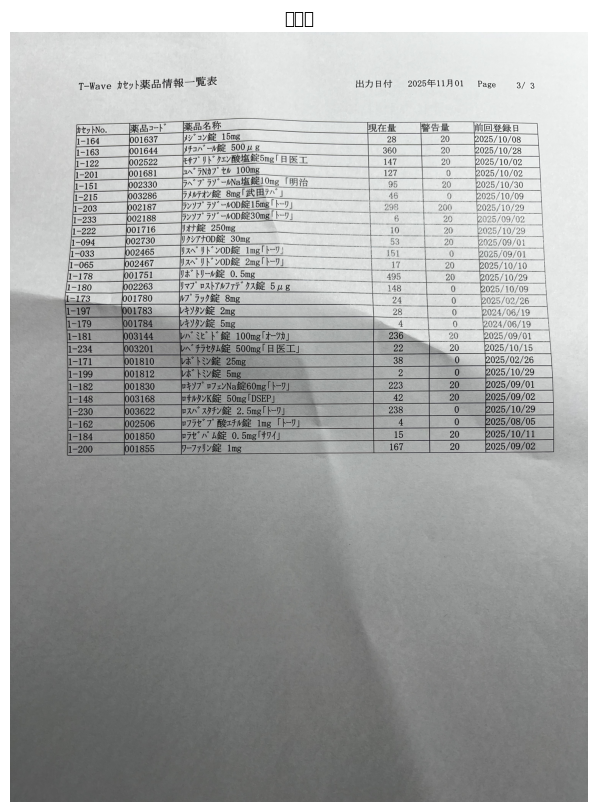

In [65]:
# ===============================
# 📘 Step 1: 画像の読み込みと表示
# ===============================
import cv2
import matplotlib.pyplot as plt

# 画像の読み込み（ファイルパスは実際のパスに変更）
img_path = "images\information\information6.jpg"
img = cv2.imread(img_path)

# 読み込み確認
print("画像サイズ:", img.shape)

# RGB形式で表示
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("元画像")
plt.axis("off")
plt.show()


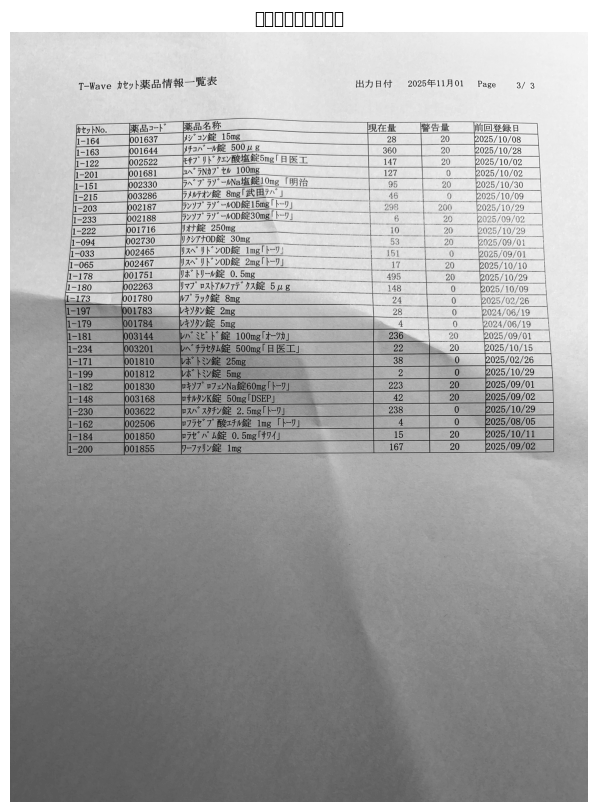

In [66]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

plt.figure(figsize=(10, 10)) 
plt.imshow(gray, cmap="gray") 
plt.title("グレースケール画像") 
plt.axis("off") 
plt.show()

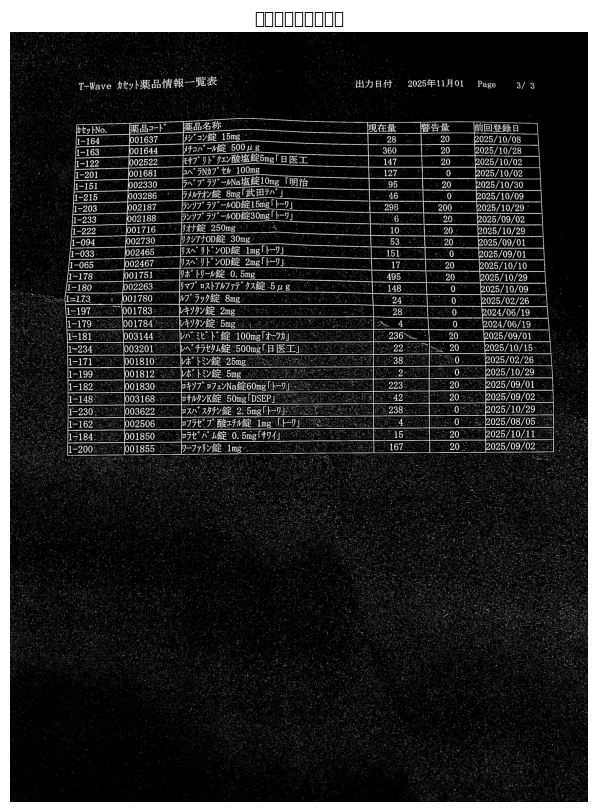

In [67]:
binary = cv2.adaptiveThreshold( gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 10 ) 

plt.figure(figsize=(10, 10)) 
plt.imshow(binary, cmap="gray") 
plt.title("二値化画像（反転）") 
plt.axis("off") 
plt.show()

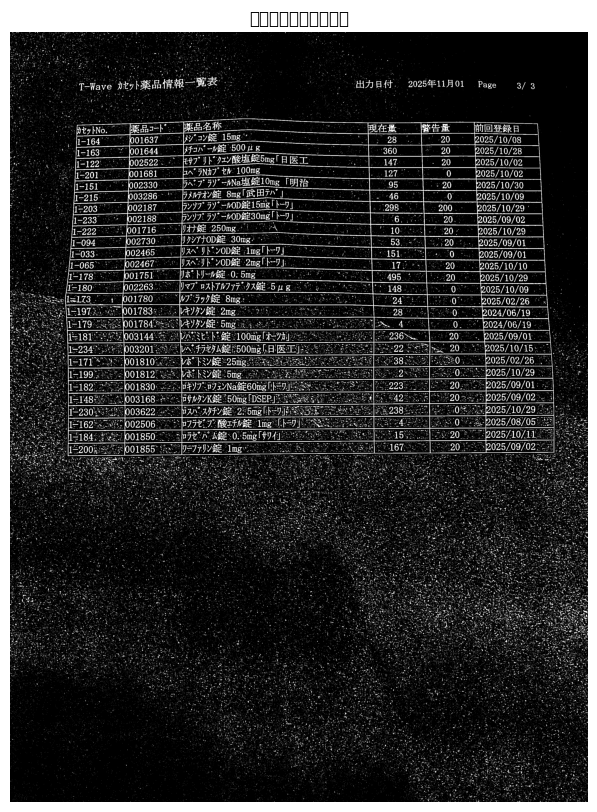

In [68]:
# ===============================
# 📘 Step 4: 線の抽出（膨張＋収縮）
# ===============================
# 水平・垂直線を強調するためのカーネル設定
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

plt.figure(figsize=(10, 10))
plt.imshow(morphed, cmap="gray")
plt.title("モルフォロジー処理後")
plt.axis("off")
plt.show()


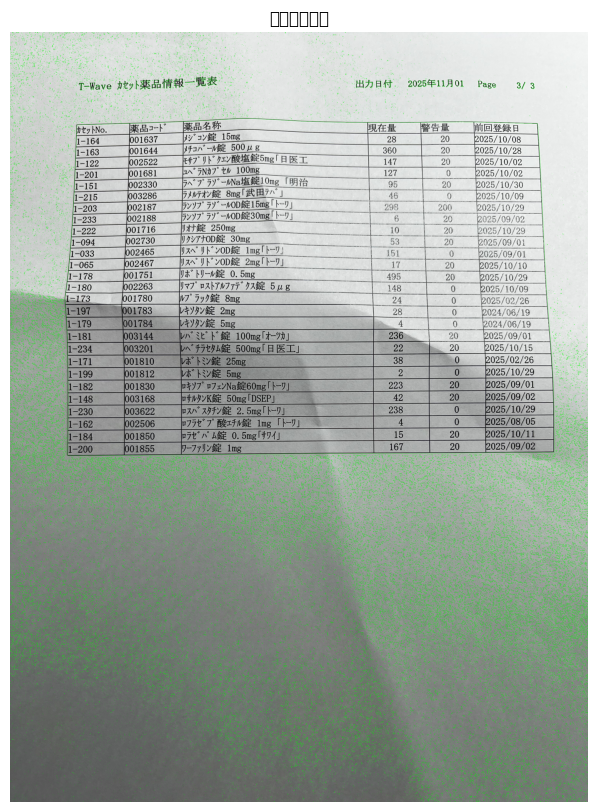

検出された輪郭数: 112126


In [69]:
# ===============================
# 📘 Step 5: 輪郭抽出
# ===============================
contours, hierarchy = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 元画像に枠を描画
img_contours = img.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 1)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
plt.title("輪郭検出結果")
plt.axis("off")
plt.show()
print("検出された輪郭数:", len(contours))


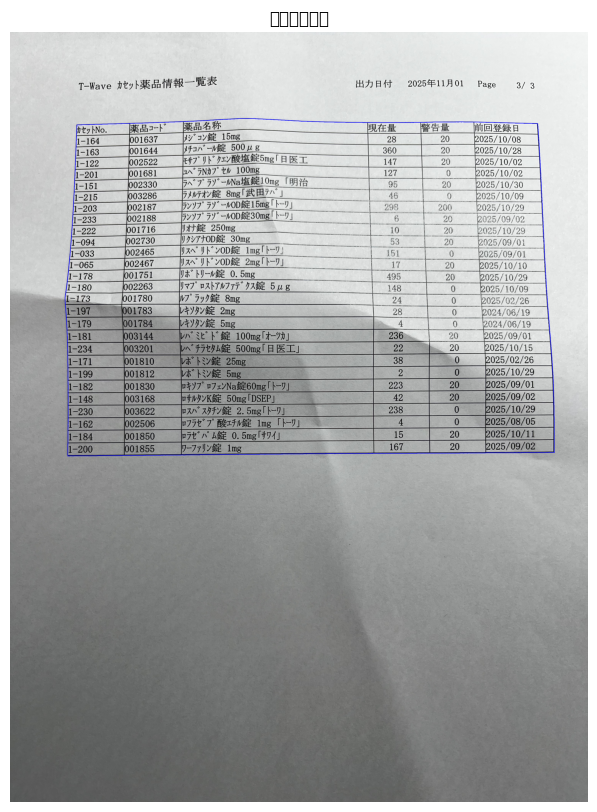

In [70]:
# ===============================
# 📘 Step 6: 表領域の抽出（大きな枠を選択）
# ===============================
# 面積が大きい輪郭だけ抽出（表全体など）
table_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 10000]

img_table = img.copy()
cv2.drawContours(img_table, table_contours, -1, (255, 0, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_table, cv2.COLOR_BGR2RGB))
plt.title("表領域の抽出")
plt.axis("off")
plt.show()


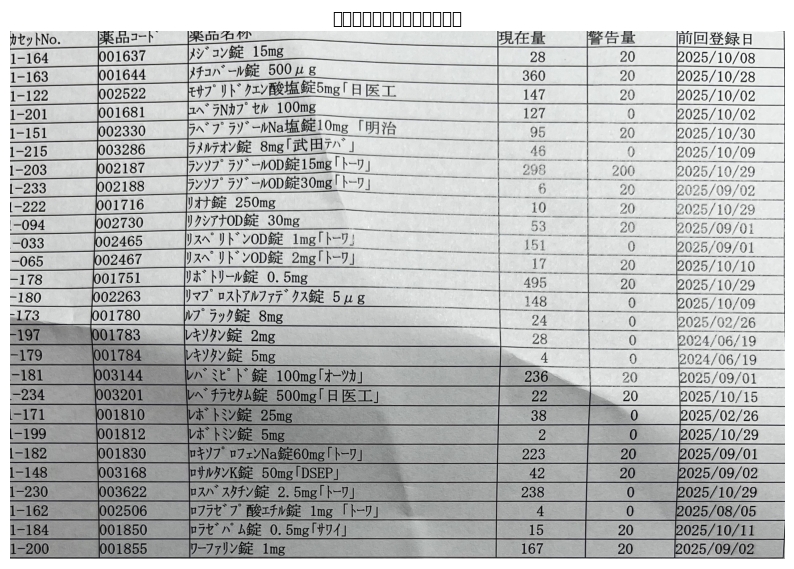

In [71]:
# ===============================
# 📘 Step 7 改良版: 表セルの分割（行ごとに）＋長方形補正
# ===============================

import numpy as np

# 最も大きい輪郭をテーブルとみなす
table_cnt = max(table_contours, key=cv2.contourArea)

# --- 輪郭の近似 ---
# 輪郭をできるだけ4つの角に近い形にする（誤差0.02倍）
peri = cv2.arcLength(table_cnt, True)
approx = cv2.approxPolyDP(table_cnt, 0.02 * peri, True)

# --- 角が4点あれば透視変換で補正 ---
if len(approx) == 4:
    # 頂点を整理
    pts = approx.reshape(4, 2)
    
    # 頂点を左上・右上・右下・左下の順に並び替え
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]  # 左上
        rect[2] = pts[np.argmax(s)]  # 右下

        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]  # 右上
        rect[3] = pts[np.argmax(diff)]  # 左下
        return rect

    rect = order_points(pts)

    # 新しい画像サイズを決める
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxWidth = int(max(widthA, widthB))
    maxHeight = int(max(heightA, heightB))

    # 変換先の座標（きれいな長方形）
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    # --- 透視変換行列を作って変換 ---
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.title("透視変換後の補正済み表領域")
    plt.axis("off")
    plt.show()

    table_img = warped  # 以降の処理で使用

else:
    # 4角が検出できなければ従来の矩形を使用
    x, y, w, h = cv2.boundingRect(table_cnt)
    table_img = img[y:y+h, x:x+w]

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(table_img, cv2.COLOR_BGR2RGB))
    plt.title("通常の切り出し表領域")
    plt.axis("off")
    plt.show()


検出された横線の本数: 98
最初の20本のy座標: [27, 38, 42, 89, 99, 103, 151, 157, 159, 214, 219, 221, 276, 282, 283, 300, 338, 342, 345, 360]


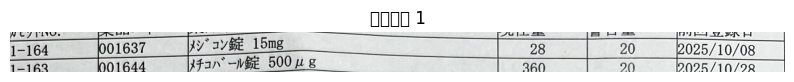

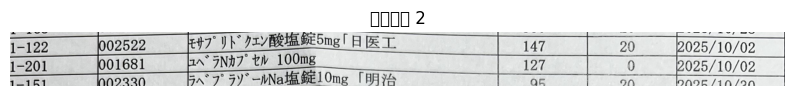

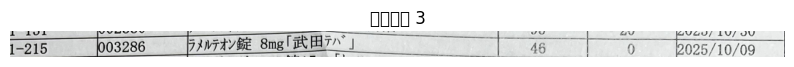

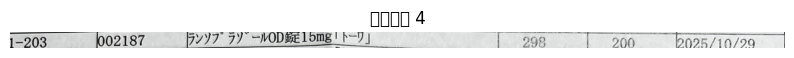

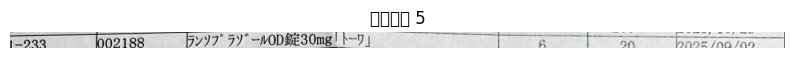

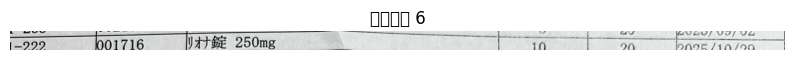

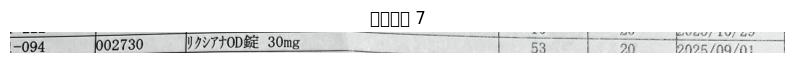

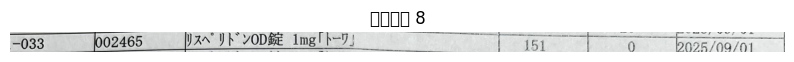

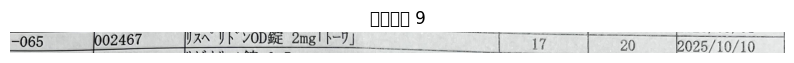

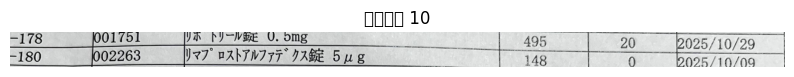

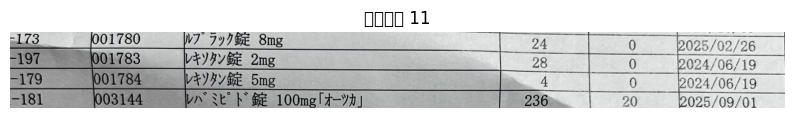

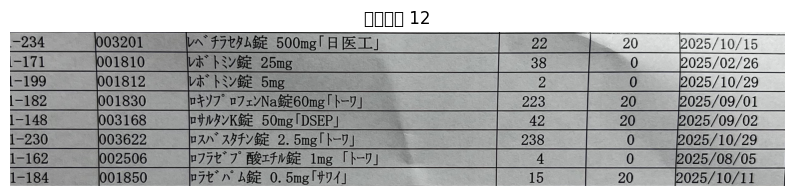

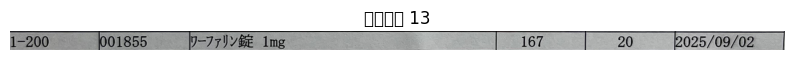

✅ 完了！保存先フォルダ: c:\Users\PC_User\Desktop\アプリ作成\OCR-DrugTableConverter\cut_rows


In [72]:
# ===============================
# 📘 Step 8.2: 横線を抽出して、8本ごとに分割・保存
# ===============================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 保存先フォルダ（なければ作成）
output_dir = "cut_rows"
os.makedirs(output_dir, exist_ok=True)

# --- 1️⃣ グレースケール化 ---
gray_table = cv2.cvtColor(table_img, cv2.COLOR_BGR2GRAY)

# --- 2️⃣ 二値化（白黒反転で線を強調）---
thresh_table = cv2.adaptiveThreshold(
    gray_table, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    15, 10
)

# --- 3️⃣ 横方向カーネルを使って「開操作」だけ実施 ---
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
opened = cv2.morphologyEx(thresh_table, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

# --- 4️⃣ 横線を検出 ---
contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])  # y座標で並べ替え

# --- 5️⃣ 各線の y座標をリストに保存 ---
y_positions = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    y_positions.append(y)

# --- 検出結果の確認 ---
print("検出された横線の本数:", len(y_positions))
print("最初の20本のy座標:", y_positions[:20])

# --- 6️⃣ y座標を8本ずつで区切って画像を分割 ---
rows = []
for i in range(0, len(y_positions) - 1, 8):
    y1 = y_positions[i]
    y2 = y_positions[min(i + 8, len(y_positions) - 1)]  # 次の8本後 or 最終線
    row = table_img[y1:y2, :]
    rows.append(row)

# --- 7️⃣ 分割結果を表示＆保存 ---
for idx, row_img in enumerate(rows):
    plt.figure(figsize=(10, 3))
    plt.imshow(cv2.cvtColor(row_img, cv2.COLOR_BGR2RGB))
    plt.title(f"分割画像 {idx+1}")
    plt.axis("off")
    plt.show()

    # 画像として保存
    save_path = os.path.join(output_dir, f"cut_part_{idx+1}.jpg")
    cv2.imwrite(save_path, row_img)

print("✅ 完了！保存先フォルダ:", os.path.abspath(output_dir))


検出された横線の本数: 98
最初の20本のy座標: [27, 38, 42, 89, 99, 103, 151, 157, 159, 214, 219, 221, 276, 282, 283, 300, 338, 342, 345, 360]


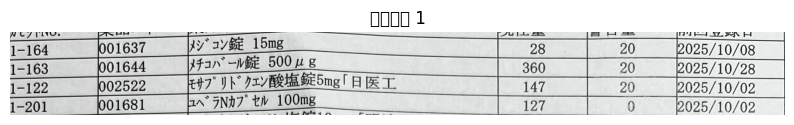

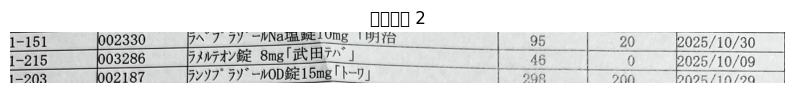

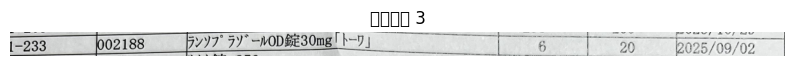

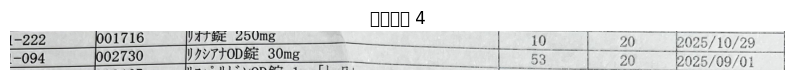

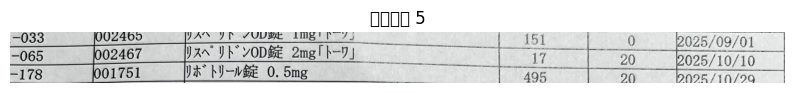

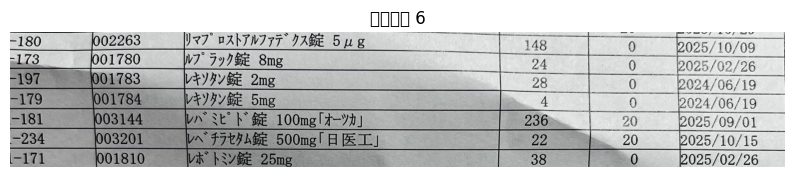

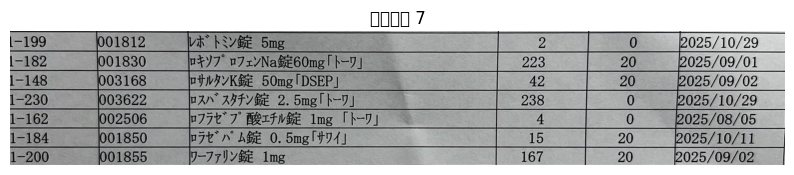

✅ 完了！保存先フォルダ: c:\Users\PC_User\Desktop\アプリ作成\OCR-DrugTableConverter\cut_rows


In [73]:
# ===============================
# 📘 Step 8.2: 横線を抽出して、15本ごとに分割・保存
# ===============================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 保存先フォルダ（なければ作成）
output_dir = "cut_rows"
os.makedirs(output_dir, exist_ok=True)

# --- 1️⃣ グレースケール化 ---
gray_table = cv2.cvtColor(table_img, cv2.COLOR_BGR2GRAY)

# --- 2️⃣ 二値化（白黒反転で線を強調）---
thresh_table = cv2.adaptiveThreshold(
    gray_table, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    15, 10
)

# --- 3️⃣ 横方向カーネルを使って「開操作」だけ実施 ---
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
opened = cv2.morphologyEx(thresh_table, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

# --- 4️⃣ 横線を検出 ---
contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])  # y座標で並べ替え

# --- 5️⃣ 各線の y座標をリストに保存 ---
y_positions = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    y_positions.append(y)

# --- 検出結果の確認 ---
print("検出された横線の本数:", len(y_positions))
print("最初の20本のy座標:", y_positions[:20])

# --- 6️⃣ y座標を15本ごとに区切って画像を分割 ---
rows = []
for i in range(0, len(y_positions) - 1, 15):
    y1 = y_positions[i]
    y2 = y_positions[min(i + 15, len(y_positions) - 1)]  # 次の15本後 or 最終線
    row = table_img[y1:y2, :]
    rows.append(row)

# --- 7️⃣ 分割結果を表示＆保存 ---
for idx, row_img in enumerate(rows):
    plt.figure(figsize=(10, 3))
    plt.imshow(cv2.cvtColor(row_img, cv2.COLOR_BGR2RGB))
    plt.title(f"分割画像 {idx+1}")
    plt.axis("off")
    plt.show()

    # 画像として保存
    save_path = os.path.join(output_dir, f"cut_part_{idx+1}.jpg")
    cv2.imwrite(save_path, row_img)

print("✅ 完了！保存先フォルダ:", os.path.abspath(output_dir))


In [ ]:
# ===============================
# 📘 Step 1: GPT-4 Vision APIで表画像の文字起こし（複数画像対応・コスト算出付き）
# ===============================

from openai import OpenAI
import base64
import os
import pandas as pd

# --- 1️⃣ APIクライアントを初期化 ---
client = OpenAI()

# --- 2️⃣ OCR対象フォルダを指定 ---
folder_path = r"C:\Users\PC_User\Desktop\アプリ作成\cut_rows"

# --- 3️⃣ OCRプロンプト設定 ---
prompt_text = """
PDFもしくは画像データを文字起こしします。
文字起こしするデータは表形式で、列は以下の6列です。
カセットNo. / 薬品コード / 薬品名称 / 現在量 / 警告量 / 前回登録日

文字起こしする際、以下のルールに従ってください。
・カセットNo.は1-から始まる5桁のデータ（例: 1-001）
・薬品コードは6桁の半角数字で、00から始まります。
・薬品名称はカタカナは半角、漢字は全角で正確に記載。
・現在量と警告量は半角数字。
・前回登録日はYYYY/MM/DD形式。
・各列のデータは必ず,で区切ってください(csv形式で出力）。
・表のデータ以外（画像名や「文字起こししました」等の文章）は一切含めないでください。
"""

# --- 4️⃣ 画像ファイルの一覧を取得 ---
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# --- 5️⃣ 結果格納用のリストを作成 ---
results = []
total_prompt_tokens = 0
total_completion_tokens = 0

# --- 6️⃣ 各画像に対してOCR実行 ---
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)

    with open(image_path, "rb") as f:
        img_bytes = f.read()
    img_base64 = base64.b64encode(img_bytes).decode("utf-8")

    response = client.chat.completions.create(
        model="gpt-4.1-mini",  # ✅ Vision対応軽量モデル
        messages=[
            {"role": "system", "content": "あなたは正確なOCR変換を行う日本語文字認識エンジンです。"},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt_text},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}}
                ]
            }
        ],
        max_tokens=2000
    )

    # --- OCR結果を取得 ---
    text_result = response.choices[0].message.content

    # --- トークン使用量を加算 ---
    usage = response.usage
    total_prompt_tokens += usage.prompt_tokens
    total_completion_tokens += usage.completion_tokens

    # --- 結果をリストに追加 ---
    results.append({
        "ファイル名": image_file,
        "文字起こし結果": text_result,
        "入力トークン": usage.prompt_tokens,
        "出力トークン": usage.completion_tokens,
        "合計トークン": usage.total_tokens
    })

# --- 7️⃣ DataFrame化して表で出力 ---
df_results = pd.DataFrame(results)
print("📋 OCR結果（各画像ごと）:")
print(df_results.to_string(index=False))

# --- 8️⃣ トークン総計とコスト計算 ---
total_tokens = total_prompt_tokens + total_completion_tokens
input_cost = total_prompt_tokens / 1000 * 0.01  # 目安：入力 0.01 USD / 1K tokens
output_cost = total_completion_tokens / 1000 * 0.03  # 目安：出力 0.03 USD / 1K tokens
total_cost = input_cost + output_cost

print("\n📊 トークン使用量（合計）:")
print(f"入力トークン（prompt）: {total_prompt_tokens}")
print(f"出力トークン（completion）: {total_completion_tokens}")
print(f"合計トークン: {total_tokens}")

print(f"\n💰 概算コスト: ${total_cost:.4f}（約¥{total_cost * 150:.2f}）")

# --- 9️⃣ CSV保存（任意）---
output_csv = os.path.join(folder_path, "ocr_results.csv")
df_results.to_csv(output_csv, index=False, encoding="utf-8-sig")
print(f"\n📁 OCR結果をCSVに保存しました: {output_csv}")


In [ ]:
# ============================================
# OCR文字起こしの整形 → 表（6列）に変換＋自動補正＋半角カタカナ→全角変換
# ============================================
import pandas as pd
import re
import unicodedata  # ← ★ 半角→全角変換に使用

# --- 1) CSVを読み込み ---
csv_path = r"C:\Users\PC_User\Desktop\アプリ作成\cut_rows\ocr_results.csv"
df_raw = pd.read_csv(csv_path)

# --- 2) ダブルクォート削除 ---
text_series = df_raw["文字起こし結果"].astype(str).str.strip('"')

# --- 3) 改行で展開 ---
tmp = pd.DataFrame({
    "ファイル名": df_raw["ファイル名"],
    "文字起こし結果": text_series
})
tmp["行リスト"] = tmp["文字起こし結果"].str.replace("\r\n", "\n").str.replace("\r", "\n")
tmp["行リスト"] = tmp["行リスト"].str.split("\n")

df_lines = tmp[["ファイル名", "行リスト"]].explode("行リスト").rename(columns={"行リスト": "行テキスト"})
df_lines = df_lines[df_lines["行テキスト"].notna() & (df_lines["行テキスト"].str.strip() != "")].copy()

# --- 4) 補正関数（カセットNo/薬品コードの正規化）---
def fix_line_format(line: str) -> str:
    original = line
    parts = [p.strip() for p in line.split(",")]

    # ---- カセットNo ----
    cassette_src = parts[0] if len(parts) >= 1 else ""
    m = re.search(r'1[-_]?(\d+)', cassette_src) or re.search(r'(\d+)', cassette_src)
    cassette_val = None
    if m:
        try:
            cassette_val = int(m.group(1))
        except ValueError:
            cassette_val = None
    if cassette_val is not None:
        if cassette_val > 999:
            print(f"⚠️ カセットNoが4桁以上のため補正: {cassette_src} → {cassette_val} → {cassette_val % 1000:03d}")
            cassette_val = cassette_val % 1000
        parts0_fixed = f"1-{cassette_val:03d}"
    else:
        print(f"⚠️ カセットNo抽出に失敗。'1-000'を仮置き: {cassette_src}")
        parts0_fixed = "1-000"

    # ---- 薬品コード ----
    drug_src = parts[1] if len(parts) >= 2 else ""
    m2 = re.search(r'(\d+)', drug_src) or re.search(r'(\d+)', original)
    drug_val = None
    if m2:
        try:
            drug_val = int(m2.group(1))
        except ValueError:
            drug_val = None
    if drug_val is not None:
        if drug_val > 999999:
            print(f"⚠️ 薬品コードが7桁以上のため末尾6桁に補正: {drug_src} → {drug_val} → {drug_val % 1_000_000:06d}")
            drug_val = drug_val % 1_000_000
        parts1_fixed = f"{drug_val:06d}"
    else:
        print(f"⚠️ 薬品コード抽出に失敗。'000000'を仮置き: {drug_src}")
        parts1_fixed = "000000"

    # ---- 差し替え ----
    if len(parts) == 0:
        parts = [parts0_fixed, parts1_fixed]
    elif len(parts) == 1:
        parts = [parts0_fixed, parts1_fixed]
    else:
        parts[0] = parts0_fixed
        parts[1] = parts1_fixed

    fixed = ",".join(parts)
    if fixed != original:
        print(f"🛠 修正: {original}  →  {fixed}")
    return fixed

# --- 5) 全行に補正を適用 ---
df_lines["行テキスト_補正後"] = df_lines["行テキスト"].apply(fix_line_format)

# --- 6) 半角カタカナ → 全角カタカナ変換 ---
#    （unicodedata.normalize('NFKC', ...) で変換可能）
df_lines["行テキスト_補正後"] = df_lines["行テキスト_補正後"].apply(
    lambda x: unicodedata.normalize('NFKC', x)
)

# --- 7) カンマで分割 ---
split_df = df_lines["行テキスト_補正後"].str.split(",", n=5, expand=True)
split_df.columns = ["カセットNo", "薬品コード", "薬品名称", "現在量", "警告量", "前回登録日"]

# --- 8) 前後空白除去 ---
for c in split_df.columns:
    split_df[c] = split_df[c].astype(str).str.strip()

# --- 9) ファイル名を付与 ---
split_df["ファイル名"] = df_lines["ファイル名"].values
split_df = split_df[["ファイル名", "カセットNo", "薬品コード", "薬品名称", "現在量", "警告量", "前回登録日"]]

# --- 10) バリデーション ---
split_df["カセットNo_OK"] = split_df["カセットNo"].str.fullmatch(r"1-\d{3}").notna()
split_df["薬品コード_OK"]  = split_df["薬品コード"].str.fullmatch(r"00\d{4}").notna()
split_df["現在量_OK"]     = split_df["現在量"].str.fullmatch(r"\d+").notna()
split_df["警告量_OK"]     = split_df["警告量"].str.fullmatch(r"\d+").notna()
split_df["前回登録日_OK"]  = split_df["前回登録日"].str.fullmatch(r"\d{4}/\d{2}/\d{2}|//").notna()

# --- 11) 型変換 ---
split_df["現在量"]  = pd.to_numeric(split_df["現在量"], errors="coerce").astype("Int64")
split_df["警告量"]  = pd.to_numeric(split_df["警告量"], errors="coerce").astype("Int64")
split_df["前回登録日_dt"] = pd.to_datetime(
    split_df["前回登録日"].replace({"//": pd.NA}),
    format="%Y/%m/%d",
    errors="coerce"
)

# --- 12) 出力 ---
print("📋 整形後の表データ（先頭5行）:")
print(split_df.head().to_string(index=False))

# --- 13) 保存 ---
out_csv = r"C:\Users\PC_User\Desktop\アプリ作成\cut_rows\ocr_table_form.csv"
split_df.to_csv(out_csv, index=False, encoding="utf-8-sig")
print(f"\n📁 保存完了: {out_csv}")
